# Everyone has tidy data important to their 🔭sc🔬ence⚗️

In [1]:
    import sklearn.datasets, pandas, ipywidgets, traitlets, functools, IPython, matplotlib, json
    %matplotlib inline

### There is no dataframe widget that stands out.

# They each care about the data.

In [2]:
    dtypes = pandas.concat(pandas.read_html('/Users/tonyfast/Data types — NumPy v1.16 Manual.html'))

    dtypes = dtypes.set_index(dtypes['Numpy type'].str.rpartition('.').iloc[:, -1].pipe(pandas.Index, name='type'))
    
    dtypes.loc['str'] = 'str', 'str', 'string'
    dtypes.loc['float64'] = dtypes.loc['float_']

In [3]:
    import graphviz

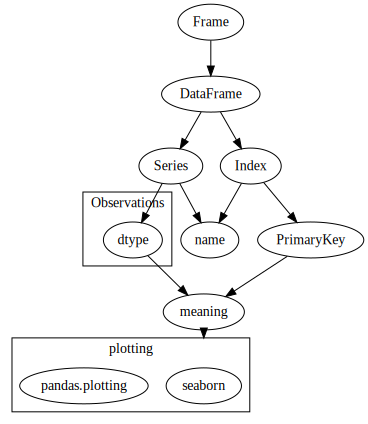

In [4]:
    graphviz.Source("""
    digraph {
        compound=True
        Frame->DataFrame->{Series Index}
        Series->{dtype name}
        Index->{PrimaryKey name}
        {dtype PrimaryKey} -> meaning -> seaborn[lhead=cluster_plotting]
        subgraph cluster_plotting {"pandas.plotting" seaborn label=plotting}
        subgraph cluster_observations {dtype label=Observations}
    }
    """)

In [5]:
    iris = sklearn.datasets.load_iris()
    df = pandas.DataFrame(iris.data, iris.target, iris.feature_names)
    df = df.set_index(pandas.CategoricalIndex(df.index))

In [6]:
    string_to_index = {key: getattr(pandas, key) for key in dir(pandas) if isinstance(getattr(pandas, key), type) and issubclass(getattr(pandas, key), pandas.Index)}
    index_to_string = dict(map(reversed, map(list, string_to_index.items())))

In [7]:
    class DataFrameWidget(ipywidgets.VBox):
        df = traitlets.Any()
        index = traitlets.Any()
        columns = traitlets.Dict()
        output = traitlets.Any()
        meaning = traitlets.Any()
        selected = traitlets.List()
        selector = traitlets.Any()
        
        def __init__(self, df):
            super().__init__(df=df, output=ipywidgets.Output(), meaning=ipywidgets.Output(), selected=list(df.columns))
            self.index= ColumnUpdateIndex(self, self.df.index)

            for column in self.df.columns:
                self.columns[column] = ColumnUpdateSeries(self, self.df[column])
            self.selector = ipywidgets.SelectMultiple(options=tuple(self.df.columns), value=tuple(self.df.columns))
            traitlets.dlink((self.selector, 'value'), (self, 'selected'))
            
            self.children = [
                self.selector, ipywidgets.HBox([self.index] + list(self.columns.values())),
                self.output, self.meaning
            ]
            self._update({})
        def _update(self, change):
            self.output.clear_output(True)
            with self.output:
                IPython.display.display(self.df.sample(5))

In [8]:
    class ColumnUpdate(ipywidgets.VBox):
        parent = traitlets.Instance(DataFrameWidget)
        series = traitlets.Instance(pandas.Series, allow_none=True)
        name = traitlets.Unicode()
        def __init__(self, parent, series):
            super().__init__(parent=parent, series=series)
            self.name = self.series.name or ''
            change_text = ipywidgets.Text(value=self.name)
            change_text.observe(self._update_name, 'value')
            
            self.children = [change_text]
            
        def _update_name(self, change):
            self.parent.df = self.parent.df.rename(columns={change['old']: change['new']})
            
    class ColumnUpdateSeries(ColumnUpdate): 
        def __init__(self, parent, series):
            super().__init__(parent=parent, series=series)
            change_type = ipywidgets.Select(options=list(dtypes.index), value=self.series.dtype.type.__name__)
            change_type.observe(self._update_type, 'value')
            
            self.children += change_type,

        def _update_name(self, change):
            assert False
            self.parent.df.index.name = change['new'] or ''
            self.parent._update()
            
        def _update_type(self, change):
            self.parent.df[self.name] = self.parent.df[self.name].astype(
                getattr(pandas.np, change['new'], str)
            )
            self.parent._update({})
            self.parent._update_meaning({})

In [9]:
    class ColumnUpdateIndex(ColumnUpdate): 
        series = traitlets.Instance(pandas.Index)
        def __init__(self, parent, series):
            super().__init__(parent=parent, series=series)
            change_type = ipywidgets.Select(options=list(string_to_index), value=index_to_string[type(self.series)])
            change_type.observe(self._update_type, 'value')
            
            self.children += change_type,

        def _update_name(self, change):
            assert False
            self.parent.df.index.name = change['new'] or ''
            self.parent._update({})
            
        def _update_type(self, change):
            get_ipython().log.error(string_to_index[change['new']](
                self.parent.df.index
            ))
            self.parent.df = self.parent.df.set_index(string_to_index[change['new']](
                self.parent.df.index
            ))
            self.parent._update_meaning({})

In [10]:
    import ipywidgets

In [11]:
    class Persona(ipywidgets.SelectionSlider):
        parent = traitlets.Any()
        def analyst_meaning(self, change):
            self = self.parent
            self.meaning.clear_output(True)
            with self.meaning:
                pandas.plotting.scatter_matrix(self.df[self.selected]
                )
                matplotlib.pyplot.show()

        def manager_meaning(self, change):
            self = self.parent
            self.meaning.clear_output(True)
            with self.meaning:
                IPython.display.display(df.describe())

        def engineer_meaning(self, change):
            self = self.parent
            self.meaning.clear_output(True)
            with self.meaning:
                IPython.display.display(
                    IPython.display.JSON(json.loads(self.df.to_json(orient='table'))))

        @traitlets.observe('value')
        def _change_persona(self,change):
            get_ipython().log.error(self)
            dict(zip("manager engineer analyst".split(), (self.manager_meaning, self.engineer_meaning, self.analyst_meaning)))[change['new']]({})

In [12]:
    w = DataFrameWidget(df=df)

In [13]:
    persona = Persona(options="manager engineer analyst".split(), parent=w)

In [14]:
    w

DataFrameWidget(children=(SelectMultiple(index=(0, 1, 2, 3), options=('sepal length (cm)', 'sepal width (cm)',…

In [15]:
    persona

Persona(options=('manager', 'engineer', 'analyst'), value='manager')